In [1]:
from models.ResNet import *
from torch.utils.data import DataLoader

## Model = ResNet18 , pretrained from ImageNet

In [2]:
import torch
PRETRAINED = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18(
        pretrained=PRETRAINED)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
device

device(type='cuda')

## ImageNet Dataset Information

In [4]:
from config import *

In [5]:
ImageNet_class_dict

{'n01440764': [0, 'tench'],
 'n01443537': [1, 'goldfish'],
 'n01484850': [2, 'great_white_shark'],
 'n01491361': [3, 'tiger_shark'],
 'n01494475': [4, 'hammerhead'],
 'n01496331': [5, 'electric_ray'],
 'n01498041': [6, 'stingray'],
 'n01514668': [7, 'cock'],
 'n01514859': [8, 'hen'],
 'n01518878': [9, 'ostrich'],
 'n01530575': [10, 'brambling'],
 'n01531178': [11, 'goldfinch'],
 'n01532829': [12, 'house_finch'],
 'n01534433': [13, 'junco'],
 'n01537544': [14, 'indigo_bunting'],
 'n01558993': [15, 'robin'],
 'n01560419': [16, 'bulbul'],
 'n01580077': [17, 'jay'],
 'n01582220': [18, 'magpie'],
 'n01592084': [19, 'chickadee'],
 'n01601694': [20, 'water_ouzel'],
 'n01608432': [21, 'kite'],
 'n01614925': [22, 'bald_eagle'],
 'n01616318': [23, 'vulture'],
 'n01622779': [24, 'great_grey_owl'],
 'n01629819': [25, 'European_fire_salamander'],
 'n01630670': [26, 'common_newt'],
 'n01631663': [27, 'eft'],
 'n01632458': [28, 'spotted_salamander'],
 'n01632777': [29, 'axolotl'],
 'n01641577': [30, 

## Read Test dataset list

In [6]:
import os
dataset = 'ImageNet'

dataset_path = '/data/ssd2/ImageNet/ImageNet_val/'

In [7]:

if dataset == 'ImageNet':
    num_class = 1000
    class_list = os.listdir(dataset_path)
    dataset_path = [dataset_path + class_name + '/' for class_name in class_list]
    
    print(len(dataset_path))

1000


In [8]:
test_list = []

for class_index in range(len(dataset_path)):
    file_list = os.listdir(dataset_path[class_index])
    file_list.sort()

    for file_index,filename in enumerate(file_list):
        test_list.append(dataset_path[class_index]+filename)

In [9]:
print(len(test_list))

50000


## Number of channel before GAP

In [10]:
in_features = model.fc.in_features
in_features

512

In [11]:
from function.Dataloader import *
from function.CAM import *

In [12]:
test_dataset = ImageNet_dataloader(path=test_list, input_size=256,num_class=num_class,cutmix_p = 0.,beta = 0.,training=False)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, num_workers=1)

In [13]:
index = 50
    
batch_images = test_dataset[index]['image']
batch_labels = test_dataset[index]['label']

In [14]:
show_information = {}
for key, value in ImageNet_class_dict.items():
    show_information[value[0]] = [key,value[1]]
    

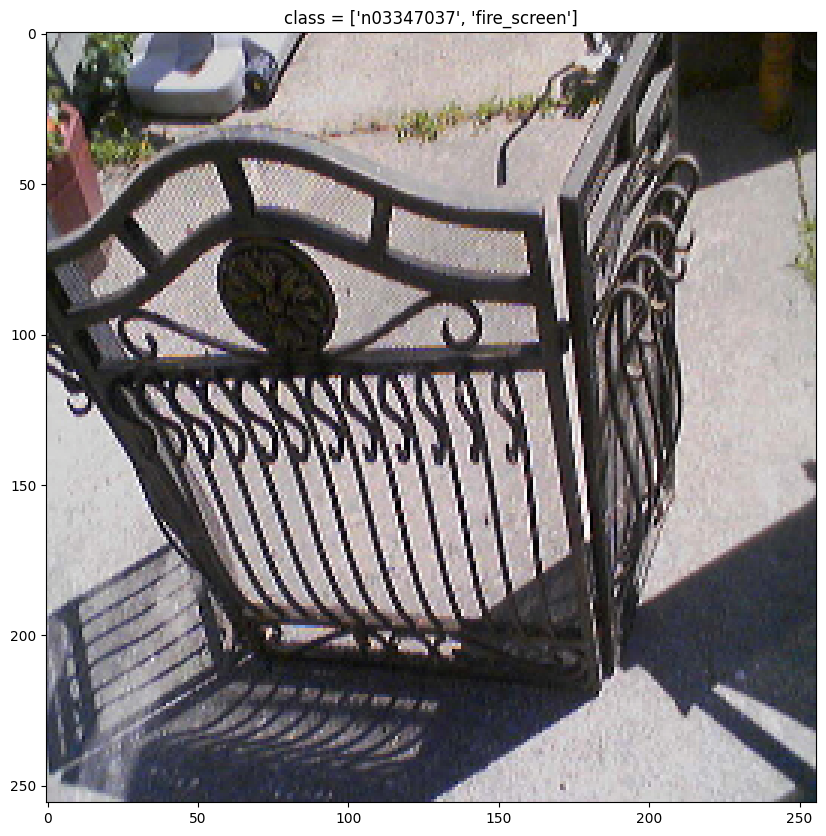

In [16]:
import matplotlib.pyplot as plt
unNormalization_method = UnNormalize()
fig = plt.subplots(1, 1, figsize=(10, 10))
plt.title(f'class = {show_information[batch_labels]}')
plt.imshow(transforms.ToPILImage()(unNormalization_method(batch_images)))


In [17]:
print(batch_labels)

556


In [18]:
features_outputs = []

In [19]:
# hook을 통하여 특정 layer의 feature output을 가져옴(CAM에서는 마지막 layer의 output을 활용함)
def hook_feature(module, input, output):
    features_outputs.append(output.data.cpu().numpy())

In [20]:
model.eval()
model.layer4.register_forward_hook(hook_feature)
with torch.no_grad():
    pred = model(batch_images.to(device).unsqueeze(0))
    # acc
    _, predict = torch.max(pred, 1)
    check_count = (predict == batch_labels).sum().item()


In [21]:
print(len(features_outputs))
print(features_outputs[0].shape)

1
(1, 512, 8, 8)


In [22]:
origin, origin_withCAM= get_cam_CIFAR10(net=model,data=batch_images.unsqueeze(0),pred=pred, features_blobs=features_outputs, classes=show_information,file_index=index)

0.278 -> ['n03125729', 'cradle']
0.232 -> ['n04099969', 'rocking_chair']
output CAM.jpg for the top1 prediction: ['n03125729', 'cradle']


In [23]:
import cv2

In [24]:
print(origin.shape)
print(origin_withCAM.shape)


(256, 256, 3)
(256, 256, 3)


In [25]:
# origin = cv2.cvtColor(origin,cv2.COLOR_BGR2RGB)
# origin_withCAM = cv2.cvtColor(origin_withCAM,cv2.COLOR_BGR2RGB)

In [26]:
import numpy as np
np.max(origin*255)

182.06999

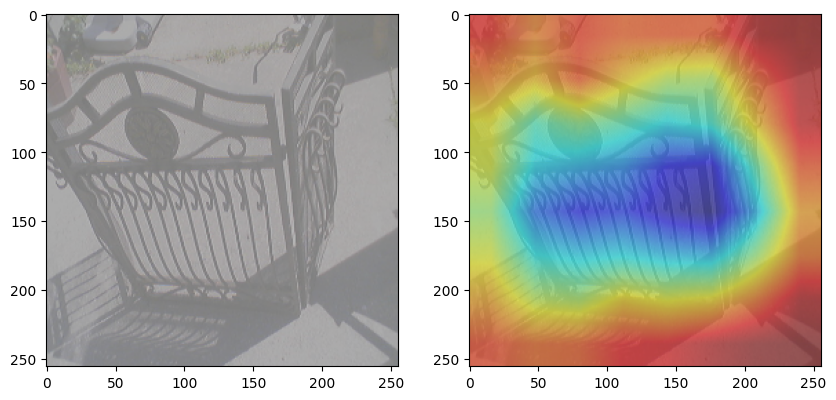

In [27]:
fig,ax = plt.subplots(1, 2, figsize=(10, 10*2))
# plt.title(f'class = {show_information[batch_labels]}')
ax[0].imshow(np.asarray(origin*255,dtype=int))
ax[1].imshow(np.asarray(0.5*(origin*255) + 0.5*origin_withCAM,dtype=int))